In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
import itertools
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

df_ajustado = pd.read_csv("Datos/Transformados/limpio.csv", index_col=0)
df_ajustado.index = pd.to_datetime(df_ajustado.index)
rent_diarias = df_ajustado.pct_change()

1º OPCIÓN: Métricas

Resumen de Rentabilidad, Riesgo y Sharpe por Activo:
      Rentabilidad Anualizada  Volatilidad Anualizada  Ratio Sharpe
AAPL                 0.388099                0.339550      1.084077
AMGN                 0.131513                0.273750      0.407355
AXP                  0.237904                0.404536      0.538651
BA                   0.024818                0.564348      0.008538
CAT                  0.162074                0.341471      0.416065


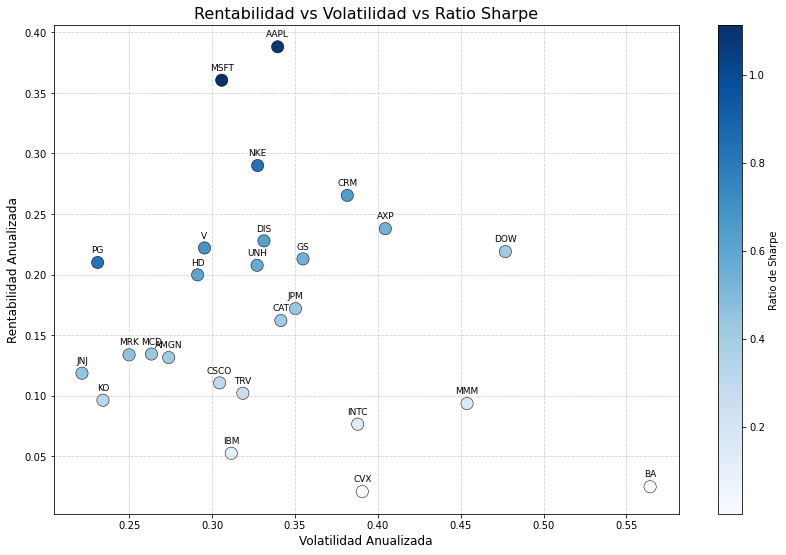

In [2]:
rentabilidad_anualizada = rent_diarias.mean() * 252
volatilidad_anualizada = rent_diarias.std() * np.sqrt(252)
risk_free_rate = 0.02 
resumen_activos = pd.DataFrame({
    'Rentabilidad Anualizada': rentabilidad_anualizada,
    'Volatilidad Anualizada': volatilidad_anualizada})
resumen_activos['Ratio Sharpe'] = (resumen_activos['Rentabilidad Anualizada'] - risk_free_rate) / resumen_activos['Volatilidad Anualizada']
print("Resumen de Rentabilidad, Riesgo y Sharpe por Activo:")
print(resumen_activos.head())
plt.figure(figsize=(14, 9))
scatter = plt.scatter(
    x=resumen_activos['Volatilidad Anualizada'],
    y=resumen_activos['Rentabilidad Anualizada'],
    c=resumen_activos['Ratio Sharpe'], 
    cmap='Blues', s=150,alpha=1,edgecolors='black', linewidths=0.5)
plt.colorbar(scatter, label='Ratio de Sharpe')
plt.title('Rentabilidad vs Volatilidad vs Ratio Sharpe', fontsize=16)
plt.xlabel('Volatilidad Anualizada', fontsize=12)
plt.ylabel('Rentabilidad Anualizada', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
for i, txt in enumerate(resumen_activos.index):
    plt.annotate(txt, (resumen_activos['Volatilidad Anualizada'][i], resumen_activos['Rentabilidad Anualizada'][i]),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
plt.show()

In [4]:
def cartera_simple(df_precios, risk_free_rate=0.0):
    returns = df_precios.pct_change().dropna()
    cov_anual = returns.cov() * 252
    resultados = []
    combinaciones = list(itertools.combinations(df_precios.columns, 3))
    for activos in combinaciones:
        pesos = np.array([1/3, 1/3, 1/3])
        sub_returns = returns[list(activos)]
        port_daily_returns = sub_returns @ pesos
        # --- Métricas financieras ---
        rent_diaria_media = port_daily_returns.mean()
        rentabilidad_anualizada = (1 + rent_diaria_media) ** 252 - 1
        sub_cov = cov_anual.loc[list(activos), list(activos)]
        volatilidad_anualizada = np.sqrt(np.dot(pesos, np.dot(sub_cov, pesos.T)))
        rentabilidad_acumulada = (1 + port_daily_returns).prod() - 1
        sharpe = (rentabilidad_anualizada - risk_free_rate) / volatilidad_anualizada if volatilidad_anualizada > 0 else np.nan
        cumulative = (1 + port_daily_returns).cumprod()
        rolling_max = cumulative.cummax()
        drawdown = (cumulative - rolling_max) / rolling_max
        max_dd = drawdown.min()
        resultados.append({
            'cartera': activos,
            'rentabilidad_anualizada': float(rentabilidad_anualizada),
            'volatilidad_anualizada': float(volatilidad_anualizada),
            'rentabilidad_acumulada': float(rentabilidad_acumulada),
            'sharpe': float(sharpe),
            'drawdown_max': float(max_dd)})
    df_resultados = pd.DataFrame(resultados)
    df_resultados = df_resultados.sort_values(
        by=['rentabilidad_anualizada', 'volatilidad_anualizada'],
        ascending=[False, False]).reset_index(drop=True)
    return df_resultados

In [5]:
cartera_simple = cartera_simple(df_ajustado,0.02)

In [6]:
cartera_simple

,cartera,rentabilidad_anualizada,volatilidad_anualizada,rentabilidad_acumulada,sharpe,drawdown_max
0,"(AAPL, GS, MSFT)",0.530659,0.297776,1.449911,1.714907,-0.338661
1,"(AAPL, MSFT, NKE)",0.511040,0.286404,1.394812,1.714497,-0.323536
2,"(AAPL, HD, MSFT)",0.496583,0.291031,1.332722,1.637567,-0.311370
3,"(AAPL, AXP, MSFT)",0.492211,0.312474,1.284822,1.511200,-0.363363
4,"(AAPL, DIS, MSFT)",0.489441,0.288089,1.313271,1.629499,-0.324336
...,...,...,...,...,...,...
2595,"(CSCO, CVX, MRK)",0.047018,0.279450,0.015990,0.096683,-0.398912
2596,"(BA, CSCO, MRK)",0.040469,0.323081,-0.030743,0.063355,-0.475937
2597,"(BA, CVX, IBM)",0.039252,0.400462,-0.096048,0.048074,-0.565919
2598,"(BA, CVX, MRK)",0.031448,0.368848,-0.086016,0.031037,-0.531783


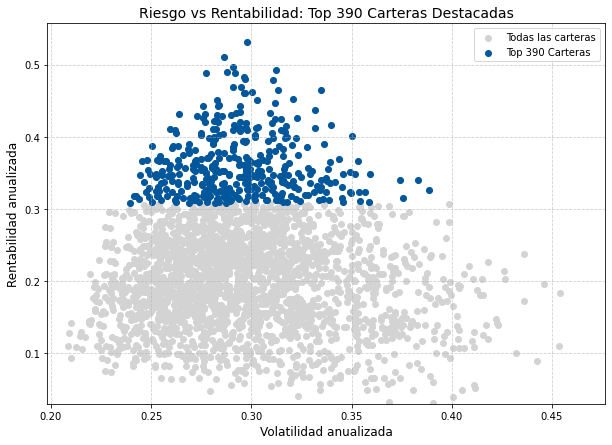

In [10]:
import matplotlib.pyplot as plt
top390 = cartera_simple.head(390)
plt.figure(figsize=(10,7))
plt.scatter(cartera_simple['volatilidad_anualizada'], cartera_simple['rentabilidad_anualizada'], 
            c='lightgray', label='Todas las carteras')
plt.scatter(top390['volatilidad_anualizada'], top390['rentabilidad_anualizada'], 
            c='#01579B', label='Top 390 Carteras')
for i, row in top390.iterrows():
    activos = ', '.join(row['cartera'])
plt.xlim(cartera_simple['volatilidad_anualizada'].min() * 0.95, cartera_simple['volatilidad_anualizada'].max() * 1.05)
plt.ylim(cartera_simple['rentabilidad_anualizada'].min() * 0.95, cartera_simple['rentabilidad_anualizada'].max() * 1.05)
plt.title('Riesgo vs Rentabilidad: Top 390 Carteras Destacadas', fontsize=14)
plt.xlabel('Volatilidad anualizada', fontsize=12)
plt.ylabel('Rentabilidad anualizada', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [11]:
def generar_carteras(df_precios, risk_free_rate=0.0):
    returns = df_precios.pct_change().dropna()
    cov_anual = returns.cov() * 252
    corr_matrix = returns.corr(method='pearson')
    resultados = []
    combinaciones = list(itertools.combinations(df_precios.columns, 3))
    for activos in combinaciones:
        pesos = np.array([1/3, 1/3, 1/3])
        sub_returns = returns[list(activos)]
        port_daily_returns = sub_returns @ pesos
        # --- Métricas financieras ---
        rent_diaria_media = port_daily_returns.mean()
        rentabilidad_anualizada = (1 + rent_diaria_media) ** 252 - 1
        sub_cov = cov_anual.loc[list(activos), list(activos)]
        volatilidad_anualizada = np.sqrt(np.dot(pesos, np.dot(sub_cov, pesos.T)))
        rentabilidad_acumulada = (1 + port_daily_returns).prod() - 1
        sharpe = (rentabilidad_anualizada - risk_free_rate) / volatilidad_anualizada if volatilidad_anualizada > 0 else np.nan
        cumulative = (1 + port_daily_returns).cumprod()
        rolling_max = cumulative.cummax()
        drawdown = (cumulative - rolling_max) / rolling_max
        max_dd = drawdown.min()
        # --- Correlaciones parciales ---
        c_ab = corr_matrix.loc[activos[0], activos[1]]
        c_ac = corr_matrix.loc[activos[0], activos[2]]
        c_bc = corr_matrix.loc[activos[1], activos[2]]
        corrs = [c_ab, c_ac, c_bc]
        corr_alta = max(corrs)
        idx_alta = corrs.index(corr_alta)
        pares = [(activos[0], activos[1]), (activos[0], activos[2]), (activos[1], activos[2])]
        par_alta = pares[idx_alta]
        tercero = list(set(activos) - set(par_alta))[0]
        corr_tercero_1 = corr_matrix.loc[tercero, par_alta[0]]
        corr_tercero_2 = corr_matrix.loc[tercero, par_alta[1]]
        corr_media_tercero = np.mean([corr_tercero_1, corr_tercero_2])
        score_corr = corr_alta - corr_media_tercero
        resultados.append({
            'cartera': activos,
            'rentabilidad_anualizada': float(rentabilidad_anualizada),
            'volatilidad_anualizada': float(volatilidad_anualizada),
            'rentabilidad_acumulada': float(rentabilidad_acumulada),
            'sharpe': float(sharpe),
            'drawdown_max': float(max_dd),
            'corr_mas_alta': float(corr_alta),
            'corr_media_tercero': float(corr_media_tercero),
            'score_corr': float(score_corr)})
    df_resultados = pd.DataFrame(resultados)
    df_resultados = df_resultados.sort_values(
        by=['score_corr','rentabilidad_anualizada'],
        ascending=[False, False]).reset_index(drop=True)
    return df_resultados

In [19]:
carteras = generar_carteras(df_ajustado,0.02)
carteras.head()

,cartera,rentabilidad_anualizada,volatilidad_anualizada,rentabilidad_acumulada,sharpe,drawdown_max,corr_mas_alta,corr_media_tercero,score_corr
0,"(AAPL, MMM, MSFT)",0.412629,0.302347,1.022666,1.298601,-0.282177,0.738265,0.246895,0.491370
1,"(GS, JPM, MMM)",0.268252,0.350003,0.512562,0.709285,-0.409218,0.849375,0.369843,0.479532
2,"(AXP, JPM, MMM)",0.236372,0.371785,0.399362,0.581982,-0.414738,0.845541,0.374648,0.470893
3,"(AXP, CRM, JPM)",0.293960,0.344340,0.594284,0.795609,-0.401152,0.845541,0.381124,0.464418
4,"(CRM, GS, JPM)",0.327319,0.323213,0.719605,0.950824,-0.377398,0.849375,0.390051,0.459325


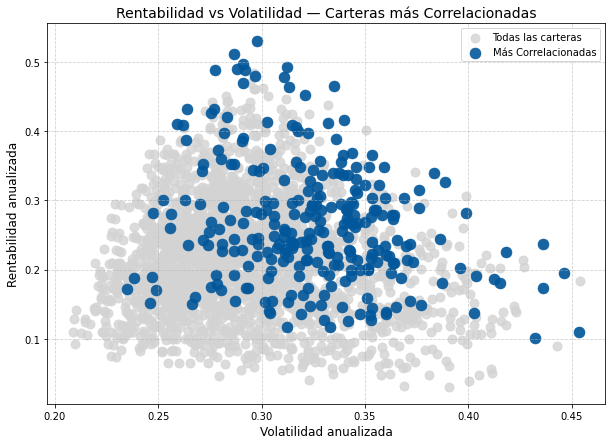

In [45]:
plt.figure(figsize=(10,7))

plt.scatter(carteras['volatilidad_anualizada'], carteras['rentabilidad_anualizada'],
            c='lightgray', s=80, alpha=0.8, label='Todas las carteras')

# Seleccionar las carteras más correlacionadas
# (por ejemplo, las 10% con mayor corr_mas_alta)
umbral_corr = carteras['corr_mas_alta'].quantile(0.9)
mas_corr = carteras[carteras['corr_mas_alta'] >= umbral_corr]

plt.scatter(mas_corr['volatilidad_anualizada'], mas_corr['rentabilidad_anualizada'],
            c="#01579B", s=120, alpha=0.9,
            linewidths=0.6, label='Más Correlacionadas')

plt.title('Rentabilidad vs Volatilidad — Carteras más Correlacionadas', fontsize=14)
plt.xlabel('Volatilidad anualizada', fontsize=12)
plt.ylabel('Rentabilidad anualizada', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

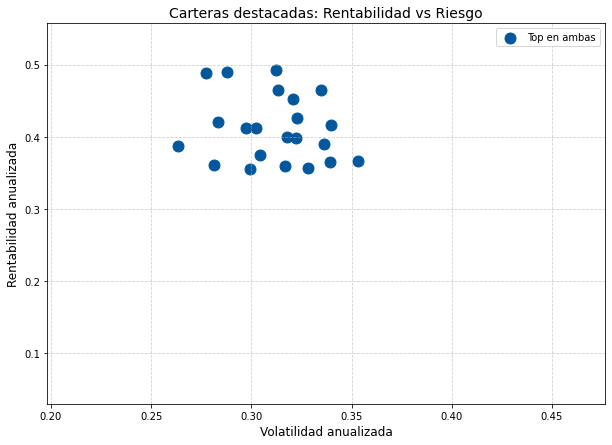

In [44]:
top_rent = carteras.nlargest(200, 'rentabilidad_anualizada')
top_score = carteras.nlargest(200, 'score_corr')
ids_comunes = top_rent.index.intersection(top_score.index)
plt.figure(figsize=(10, 7))
if len(ids_comunes) > 0:
    coincidentes = carteras.loc[ids_comunes]
    plt.scatter(coincidentes['volatilidad_anualizada'], coincidentes['rentabilidad_anualizada'],
                c="#01579B",s=120, label='Top en ambas')
for i, row in carteras.loc[top_rent.index.union(top_score.index)].iterrows():
    activos = ', '.join(row['cartera'])
plt.xlim(carteras['volatilidad_anualizada'].min() * 0.95, carteras['volatilidad_anualizada'].max() * 1.05)
plt.ylim(carteras['rentabilidad_anualizada'].min() * 0.95, carteras['rentabilidad_anualizada'].max() * 1.05)
plt.title('Carteras destacadas: Rentabilidad vs Riesgo', fontsize=14)
plt.xlabel('Volatilidad anualizada', fontsize=12)
plt.ylabel('Rentabilidad anualizada', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [46]:
coincidentes.head()

,cartera,rentabilidad_anualizada,volatilidad_anualizada,rentabilidad_acumulada,sharpe,drawdown_max,corr_mas_alta,corr_media_tercero,score_corr
180,"(AAPL, AXP, MSFT)",0.492211,0.312474,1.284822,1.511200,-0.363363,0.738265,0.460310,0.277955
142,"(AAPL, DIS, MSFT)",0.489441,0.288089,1.313271,1.629499,-0.324336,0.738265,0.444922,0.293342
47,"(AAPL, CAT, MSFT)",0.488446,0.277377,1.325639,1.688841,-0.303350,0.738265,0.384560,0.353704
107,"(AAPL, AXP, GS)",0.464773,0.334828,1.151035,1.328364,-0.413181,0.769597,0.459855,0.309742
82,"(AAPL, DOW, MSFT)",0.464274,0.313355,1.180799,1.417800,-0.371732,0.738265,0.413036,0.325229


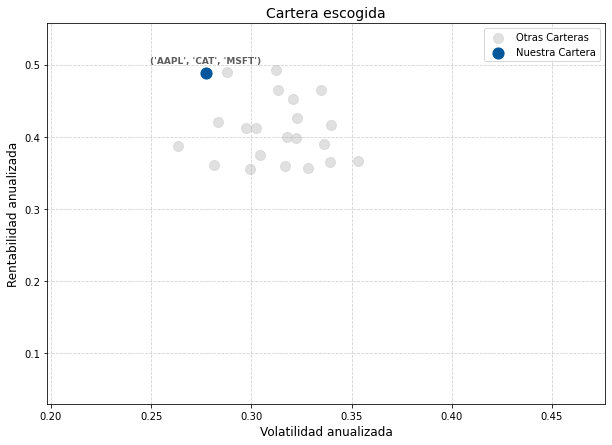

In [52]:
plt.figure(figsize=(10,7))
plt.scatter(coincidentes['volatilidad_anualizada'], coincidentes['rentabilidad_anualizada'],
            c='lightgray', s=100, alpha=0.7, label='Otras Carteras')

cartera_objetivo = ('AAPL', 'CAT', 'MSFT')
mask = coincidentes['cartera'] == cartera_objetivo

plt.scatter(coincidentes.loc[mask, 'volatilidad_anualizada'],
            coincidentes.loc[mask, 'rentabilidad_anualizada'],
            c='#01579B', s=120, alpha=1.0, linewidths=1.2,
            label='Nuestra Cartera')

for idx in coincidentes.loc[mask].index:
    x = coincidentes.loc[idx, 'volatilidad_anualizada']
    y = coincidentes.loc[idx, 'rentabilidad_anualizada']
    plt.annotate(f"{cartera_objetivo}", 
                 (x, y),
                 textcoords="offset points", xytext=(0,10), ha='center',
                 fontsize=9, color="#5E5E5E", fontweight='bold')

plt.xlim(carteras['volatilidad_anualizada'].min() * 0.95, carteras['volatilidad_anualizada'].max() * 1.05)
plt.ylim(carteras['rentabilidad_anualizada'].min() * 0.95, carteras['rentabilidad_anualizada'].max() * 1.05)

plt.title('Cartera escogida', fontsize=14)
plt.xlabel('Volatilidad anualizada', fontsize=12)
plt.ylabel('Rentabilidad anualizada', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


### A PARTIR DE AQUI NO

2º OPCIÓN: Métricas Sharpe

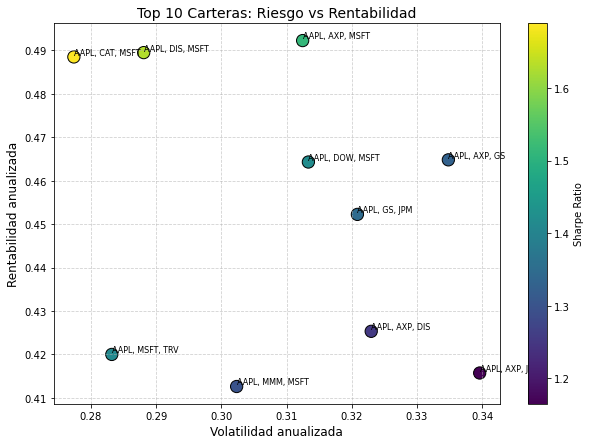

In [18]:
top10 = coincidentes.head(10)
plt.figure(figsize=(10,7))
plt.scatter(top10['volatilidad_anualizada'], top10['rentabilidad_anualizada'], 
            c=top10['sharpe'], cmap='viridis', s=150, edgecolor='black')
for i, row in top10.iterrows():
    activos = ', '.join(row['cartera'])
    plt.text(row['volatilidad_anualizada'], row['rentabilidad_anualizada'], activos, fontsize=8, ha='left', va='bottom')
plt.title('Top 10 Carteras: Riesgo vs Rentabilidad', fontsize=14)
plt.xlabel('Volatilidad anualizada', fontsize=12)
plt.ylabel('Rentabilidad anualizada', fontsize=12)
plt.colorbar(label='Sharpe Ratio')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

3º OPCIÓN: Métricas Drawdown

In [ ]:
top10 = coincidentes.head(10)
plt.figure(figsize=(10,7))
plt.scatter(
    top10['volatilidad_anualizada'],top10['rentabilidad_anualizada'],
    c=top10['drawdown_max'],cmap='RdYlGn_r',s=100,edgecolor='black')
for i, row in top10.iterrows():
    activos = ', '.join(row['cartera'])
    plt.text(row['volatilidad_anualizada'], row['rentabilidad_anualizada'], activos, fontsize=8, ha='left', va='bottom')
plt.colorbar(label='Drawdown máximo')
plt.xlabel('Volatilidad anualizada')
plt.ylabel('Rentabilidad anualizada')
plt.title('Carteras: Riesgo vs Rentabilidad (color = drawdown)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

4º OPCIÓN: Métricas

In [ ]:
top10 = coincidentes.head(10)
plt.figure(figsize=(10,7))
plt.scatter(
    top10['volatilidad_anualizada'],top10['rentabilidad_anualizada'],
    c=top10['sharpe'],s=(1 - top10['drawdown_max']) * 300,  
    cmap='viridis',edgecolor='black',alpha=0.8)
for i, row in top10.iterrows():
    activos = ', '.join(row['cartera'])
    plt.text(row['volatilidad_anualizada'], row['rentabilidad_anualizada'], activos, fontsize=8, ha='left', va='bottom')
plt.xlabel('Volatilidad anualizada')
plt.ylabel('Rentabilidad anualizada')
plt.title('Riesgo vs Rentabilidad (color=Sharpe, tamaño=drawdown)')
plt.colorbar(label='Sharpe ratio')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

5º OPCIÓN: Correlación (seleccion_de_cartera.ipynb)

In [ ]:
cols_numericas = df_ajustado.select_dtypes(include=[np.number]).columns
df_pct = df_ajustado[cols_numericas].pct_change()

In [ ]:
corr_matrix = df_pct.corr()
corr_abs = corr_matrix.abs()
np.fill_diagonal(corr_abs.values, np.nan)
diversificacion = corr_abs.sum().sort_values()
activos_diversificados = diversificacion.head(3).index.tolist()
print("Activos recomendados para diversificar:", activos_diversificados)

6º OPCIÓN: Combinación de métricas + correlación

In [ ]:
df_pct = df_ajustado.pct_change().dropna()
corr_matrix = df_pct.corr()
corr_abs = corr_matrix.abs()
np.fill_diagonal(corr_abs.values, np.nan)
diversificacion = corr_abs.sum().sort_values()
n_activos_diversificados = 18
activos_diversificados = diversificacion.head(n_activos_diversificados).index.tolist()
print("Activos más diversificados:", activos_diversificados)


In [ ]:
import itertools
combinaciones = list(itertools.combinations(activos_diversificados, 3))
print(f"Se evaluarán {len(combinaciones)} combinaciones de 3 activos.")

In [ ]:
df_filtrado = df_ajustado[activos_diversificados]
carteras_filtradas = generar_carteras(df_filtrado)
top10 = carteras_filtradas.sort_values(by='sharpe', ascending=False).head(10)
top10

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(carteras_filtradas['volatilidad_anualizada'], carteras_filtradas['rentabilidad_anualizada'], 
            c='lightgray', label='Todas las carteras')
plt.scatter(top10['volatilidad_anualizada'], top10['rentabilidad_anualizada'], 
            c='red', marker='*', s=200, label='Top 10 Carteras')
for i, row in top10.iterrows():
    activos = ', '.join(row['cartera'])
    plt.text(row['volatilidad_anualizada'], row['rentabilidad_anualizada'], activos, fontsize=8, ha='left', va='bottom')
plt.title('Top 10 Carteras Diversificadas: Riesgo vs Rentabilidad', fontsize=14)
plt.xlabel('Volatilidad anualizada', fontsize=12)
plt.ylabel('Rentabilidad anualizada', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()